<a href="https://colab.research.google.com/github/graphlit/graphlit-evals/blob/main/tonic-validate/Tonic_Validate_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install --upgrade tonic_validate

In [20]:
!pip install --upgrade langchain

In [21]:
!pip install --upgrade langchain_openai

In [22]:
!pip install --upgrade langchain-chroma

In [23]:
!pip install --upgrade langchain-cohere

In [24]:
!pip install --upgrade langchainhub

In [25]:
!pip install --upgrade unstructured

In [26]:
import os
from typing import Optional
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import time
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata

In [27]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# configure shared, writable folder containing sample data
tonic_validate_directory = "/content/drive/MyDrive/Colab Notebooks/Tonic Validate"

Mounted at /content/drive


Initialize LangChain

In [28]:
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from langchain_community.llms import Cohere

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['COHERE_API_KEY'] = userdata.get('COHERE_API_KEY')

Load benchmark questions & answers

In [29]:
with open(f"{tonic_validate_directory}/Sample Data/qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

Define LangChain helper functions

In [30]:
def upload_essays():
    directory = f"{tonic_validate_directory}/Sample Data/paul_graham_essays"

    start_time = time.time()

    loader = DirectoryLoader(directory, show_progress=True)
    docs = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    split_docs = text_splitter.split_documents(docs)
    vectorstore = Chroma.from_documents(documents=split_docs, embedding=OpenAIEmbeddings())

    duration = time.time() - start_time

    current_time = datetime.now()
    formatted_time = current_time.strftime("%H:%M:%S")

    print(f"Uploading essays took {duration:.2f} seconds. Finished at {formatted_time} UTC.")

    return vectorstore

Define LangChain RAG function

In [31]:
from langchain_openai import ChatOpenAI
from langchain import hub

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def get_langchain_rag_response(benchmarkItem: BenchmarkItem):
    prompt = benchmarkItem.question

    llm = ChatOpenAI(model="gpt-4-turbo")

    rag_prompt = hub.pull("rlm/rag-prompt")

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | rag_prompt
        | llm
        | StrOutputParser()
    )

    return rag_chain.invoke(prompt)

Initialize LangChain test

In [32]:
vectorstore = upload_essays()

vector_retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 10})

llm = Cohere(temperature=0)
compressor = CohereRerank()

retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=vector_retriever
)


100%|██████████| 212/212 [00:43<00:00,  4.92it/s]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Uploading essays took 97.69 seconds. Finished at 05:41:46 UTC.


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Cohere` was deprecated in LangChain 0.1.14 and will be removed in 0.2.0. An updated version of the class exists in the langchain-cohere package and should be used instead. To use it run `pip install -U langchain-cohere` and import as `from langchain_cohere import Cohere`.
  warn_deprecated(


Validate LangChain response

In [ ]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_langchain_rag_response(benchmark_item))

Perform LangChain test and score run

In [ ]:
raw_langchain_responses = []
for x in tqdm(benchmark.items):
    raw_langchain_responses.append(get_langchain_rag_response(x))

In [ ]:
langchain_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_langchain_responses, benchmark.items)
]

In [33]:
scorer = ValidateScorer(model_evaluator="gpt-4-turbo", metrics=[AnswerSimilarityMetric()])
langchain_run = scorer.score_run(langchain_responses, parallelism=5)


Scoring responses:   0%|          | 0/55 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

Scoring responses:   2%|▏         | 1/55 [00:00<00:27,  1.97it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

Scoring responses:   7%|▋         | 4/55 [00:00<00:08,  6.13it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

Scoring responses:  11%|█         | 6/55 [00:01<00:07,  6.85it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

Scoring respons

In [34]:
langchain_run_df = run_to_dataframe(langchain_run)
langchain_run_df.to_csv(f"{tonic_validate_directory}/langchain_run.csv", index=False)

Visualize LangChain test

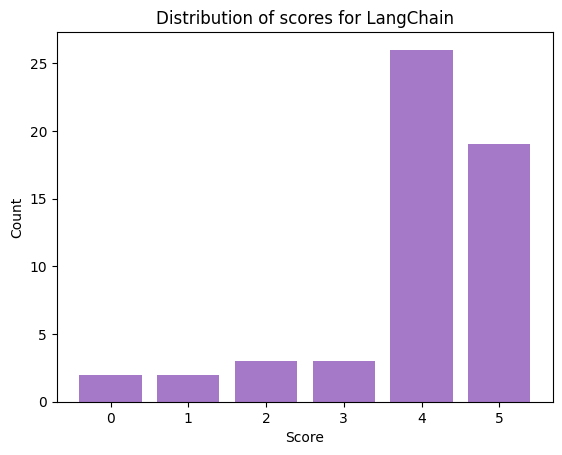

In [35]:
langchain_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in langchain_run.run_data])
category_counts = langchain_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for LangChain')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()